# Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preparation import prepare_data, filter_ravdess_files, extract_features
import librosa.display
import seaborn as sns

## RAVDESS Dataset

Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

### File Naming Convention

Each file in the RAVDESS dataset is named using a specific convention:

'''
Copymodality-vocal_channel-emotion-emotional_intensity-statement-repetition-actor.wav
'''

For example: `03-01-04-01-02-01-12.wav` 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
    
- Vocal channel (01 = speech, 02 = song)
    
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    
- Emotional intensity (01 = normal, 02 = strong)
    
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
    
- Repetition (01 = 1st repetition, 02 = 2nd repetition)
    
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)


For our project, we focus on these parameters:

- Modality: 03 (audio-only)

- Vocal channel: 01 (speech)

- Emotions: 01 (neutral), 03 (happy), 04 (sad), 05 (angry)

- Include both emotional intensities and statements

- Include all actors and repetitions

### Feature Extraction

Librosa library is used to extract the features from the audio files. The features extracted are:

- Mel-frequency Cepstral Coefficients (MFCC) (13 in number)

    - Description: MFCCs are derived from the Mel scale, which approximates the human ear's response to sound. This makes them appropriate for audio processing tasks.

    - Purpose: They are used to capture the timbral texture of the audio, which is useful for tasks such as speech and speaker recognition.

- Spectral Centroid

    - Description: The spectral centroid indicates where the "center of mass" of the spectrum is located. This is similar to a weighted mean of the frequencies present in the signal.

    - Purpose: It is a measure of the brightness of a sound. Higher values of spectral centroid correspond to brighter sounds.

- Zero Crossing Rate

    - Description: The zero-crossing rate is the rate at which the signal changes sign. It is the number of times the waveform crosses the horizontal axis.

    - Purpose: This feature is useful in distinguishing between voiced and unvoiced sounds, and in general audio classification tasks.

- Root Mean Square Energy (RMSE)

    - Description: RMSE is the square root of the average of the squares of all the values in the waveform.

    - Purpose: It is a measure of the loudness of the audio signal and is useful for identifying segments of high and low energy within the audio.

- Chroma Feature

    - Description: Chroma features represent the 12 different pitch classes. They are typically used to identify harmonic and melodic content in music.

    - Purpose: These features are particularly useful for music information retrieval tasks such as chord recognition and key detection.

- Mel Spectrogram

    - Description: A Mel spectrogram is a spectrogram where the frequencies are converted to the Mel scale. It provides a visual representation of the spectrum of frequencies in a sound signal as it varies with time.

    - Purpose: It is used for various tasks including speech recognition, audio classification, and music analysis.

- Spectral Contrast

    - Description: Spectral contrast measures the difference in amplitude between peaks and valleys in a sound spectrum.

    - Purpose: It is useful for distinguishing between different types of sounds and timbres.

- Tonnetz (Tonal Centroid Features)

    - Description: Tonnetz features represent the harmonic relations between pitches in an audio signal.

    - Purpose: These features are useful for tasks such as chord recognition and music genre classification.

We then combine all these features into a single feature vector for each audio file. The feature vectors are then used to train the model.

**Data Filtering and Feature Extraction**

In [18]:
from src.data_preparation import prepare_data

base_directory = './data/audio_speech_actors_01-24'

output_file = './data/ravdess_features.csv'

df = prepare_data(base_directory, output_file)
print(f"Total files processed: {len(df)}")
print("\nFiles per emotion:")
print(df['emotion'].value_counts())
print("\nFiles per actor:")
print(df['actor'].value_counts())

Total files processed: 672

Files per emotion:
emotion
angry      192
sad        192
happy      192
neutral     96
Name: count, dtype: int64

Files per actor:
actor
Actor_12    28
Actor_24    28
Actor_06    28
Actor_22    28
Actor_23    28
Actor_15    28
Actor_18    28
Actor_02    28
Actor_14    28
Actor_20    28
Actor_10    28
Actor_08    28
Actor_09    28
Actor_13    28
Actor_17    28
Actor_11    28
Actor_05    28
Actor_07    28
Actor_19    28
Actor_04    28
Actor_21    28
Actor_01    28
Actor_03    28
Actor_16    28
Name: count, dtype: int64


**Load the data**

In [22]:
file_path = './data/ravdess_features.csv'
df = pd.read_csv(file_path)

**Distribution of the dataset is as follows:**

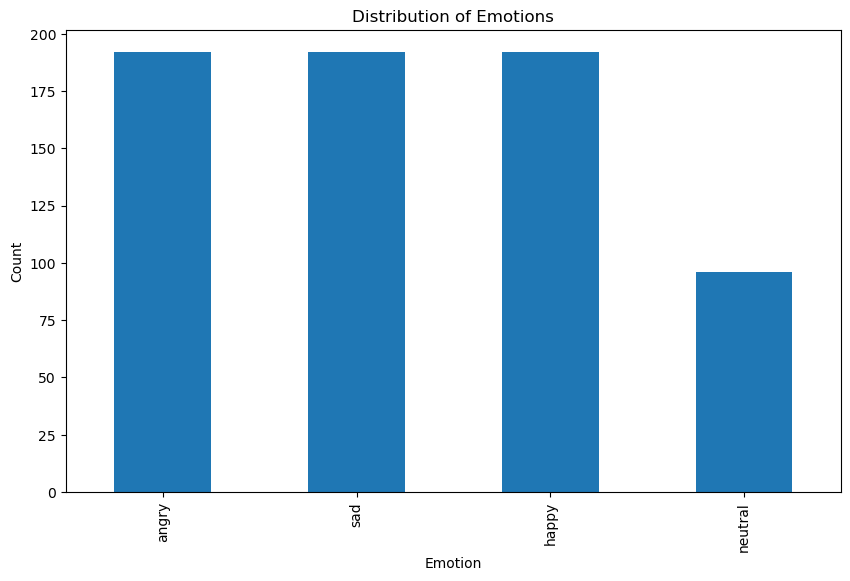

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
df['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

**Features extracted from a sad emotion audio file:**

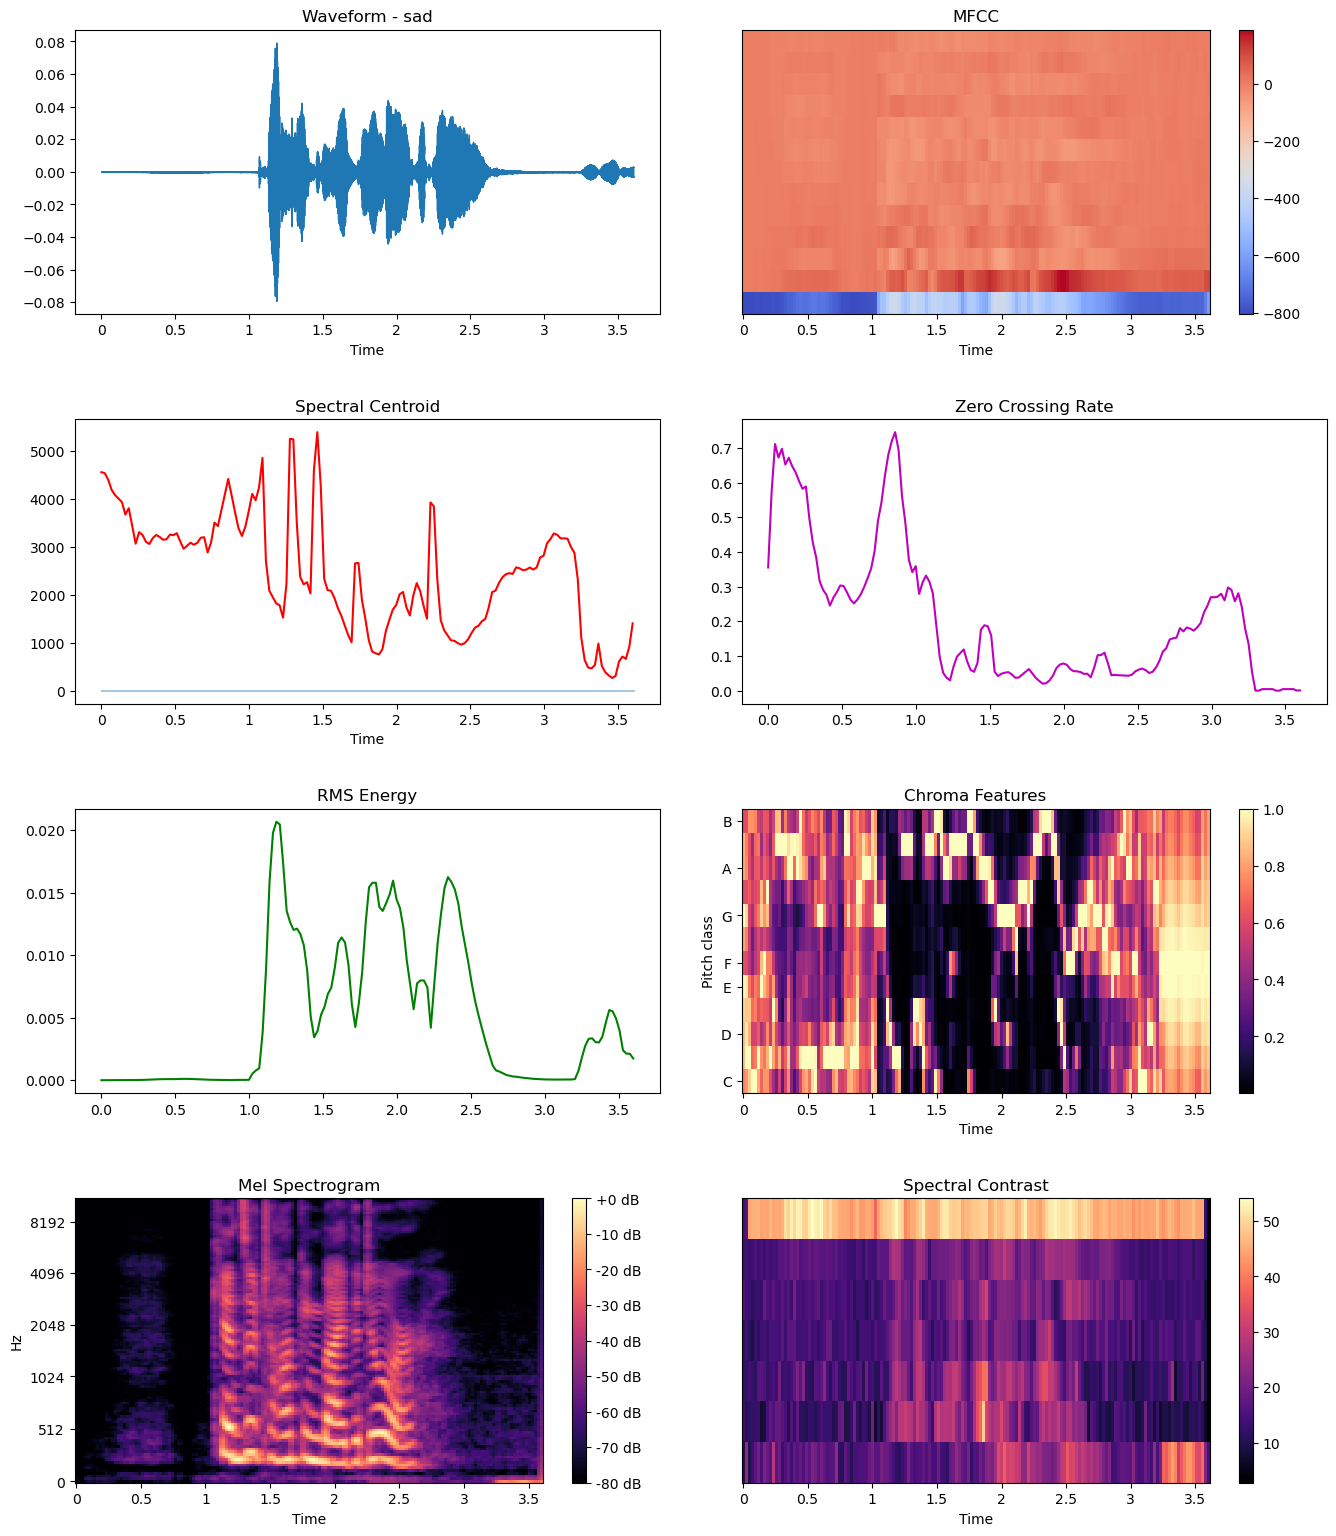

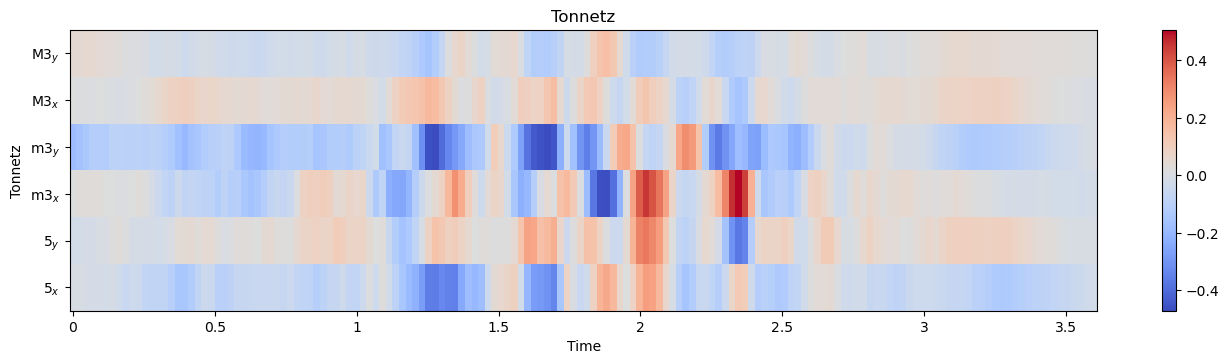

In [25]:
from src.helpers import plot_features

file_path = './data/ravdess_features.csv'
df = pd.read_csv(file_path)

sample_index = 1 # Emotion: Sad
plot_features(df, sample_index)

# print spectral centroid features for the sample
# print(df.loc[sample_index, ['spectral_centroid']])

**Features extracted from a happy emotion audio file:**

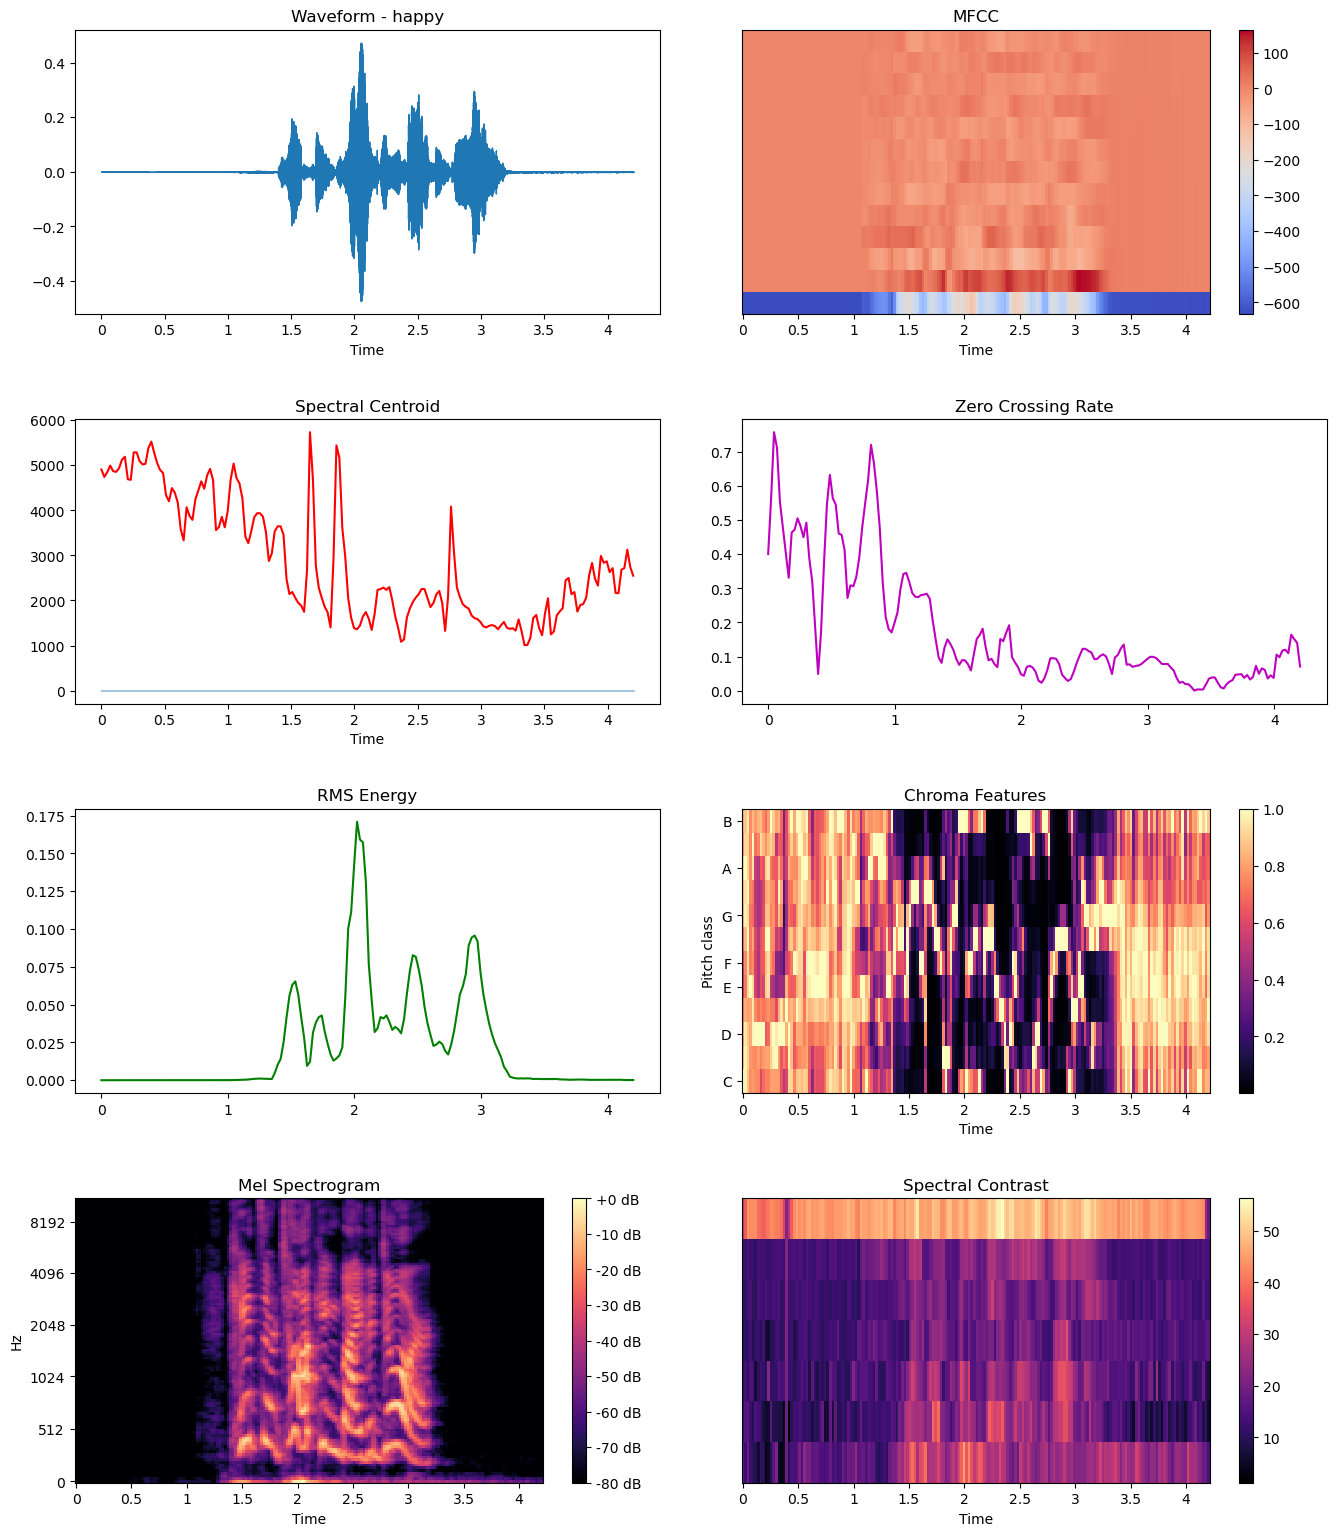

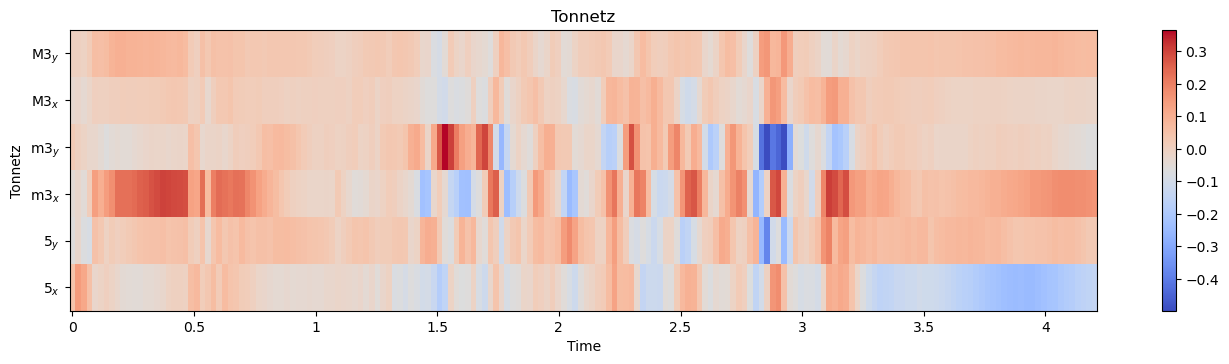

In [27]:
from src.helpers import plot_features

file_path = './data/ravdess_features.csv'
df = pd.read_csv(file_path)

sample_index = 3 # Emotion: Happy
plot_features(df, sample_index)

**Comparison of the features extracted from the audio files of different emotions:**

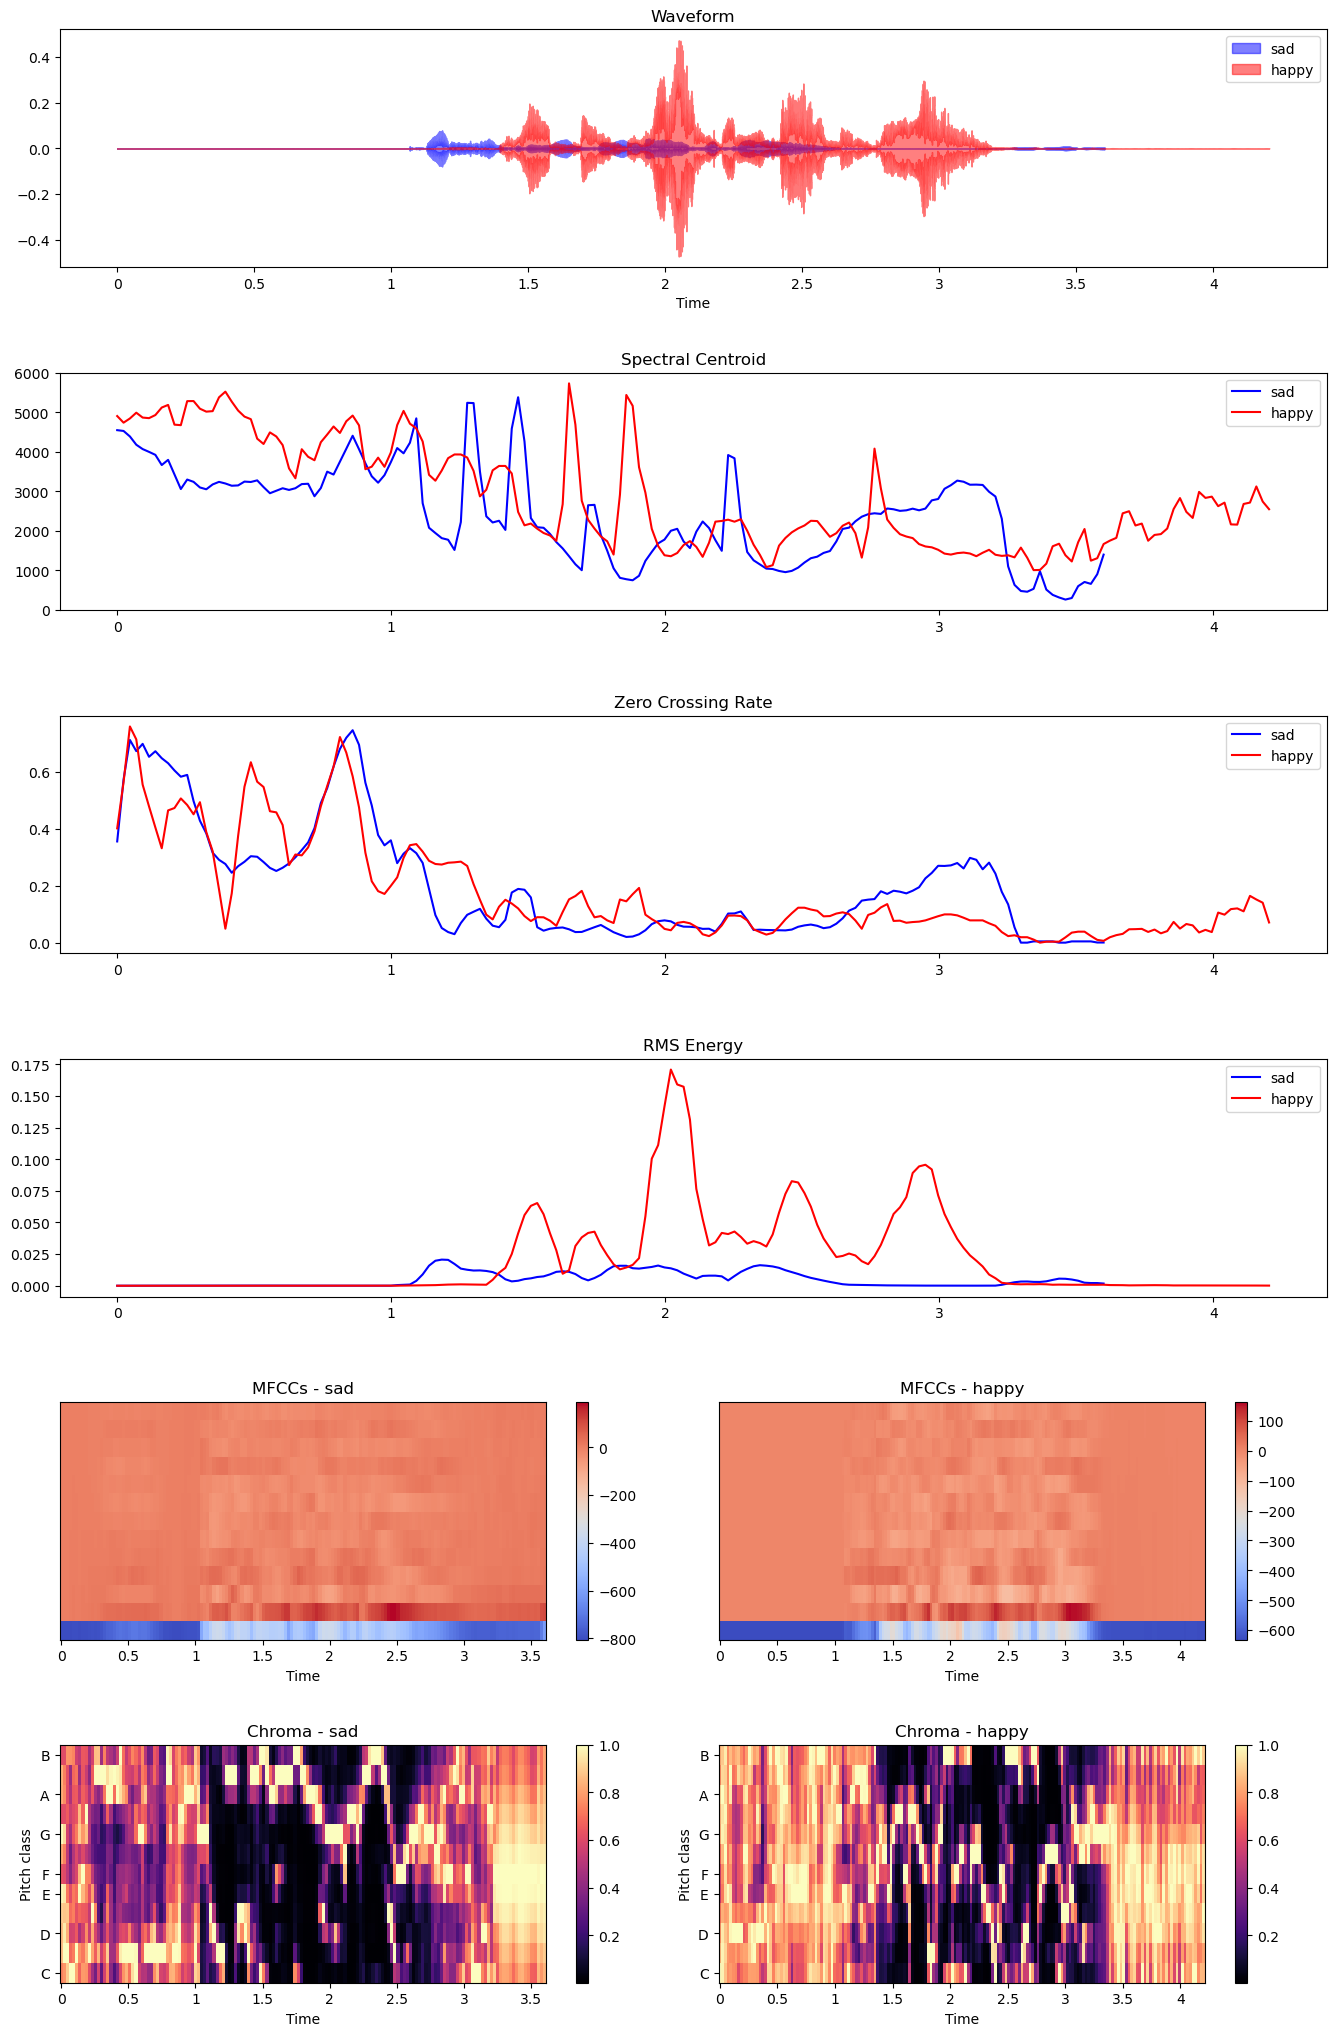

In [28]:
from src.helpers import plot_comparison

plot_comparison(df, 1, 3)

## Classical Dynamic Time Warping (DTW) vs. FastDTW

### Introduction
In this session, we compare the performance of Classical Dynamic Time Warping (DTW) and FastDTW in the context of emotion detection using audio features. The comparison focuses on several key aspects: accuracy, speed, and scalability. Since we are purely comparing their performance without any other training or factors, this is how we structured the experiment. The purpose of the algorithm is to find out the comparison of the two in terms of speed, accuracy, and scalability. This will help us choose the best algorithm for implementing more sophisticated models, like deep learning, to save time and be efficient.

### Experiment Setup
We conducted experiments using two distance metrics (classical DTW and derivative DTW) for both Classical DTW and FastDTW. We optimized the feature weights for each metric using Bayesian optimization (BayesSearchCV) with five iterations. The audio features considered were MFCCs, chroma, spectral centroid, zero crossing rate, and RMS. The results include the best parameters and the corresponding accuracy scores for each method.

### Mood Classification Model

#### Mood Template

**Create templates for each emotion using the following selected features**

- MFCCs (Mel-Frequency Cepstral Coefficients)

    - MFCCs are excellent for speech analysis as they approximate the human auditory system's response. They capture the overall spectral envelope of the speech signal, which is crucial for emotion recognition.


- Chroma Features

    - Chroma features represent the tonal content of audio. In speech, they can help capture pitch and intonation changes associated with different emotions.


- Spectral Centroid

    - The spectral centroid is related to the "brightness" of a sound. It can help distinguish between "darker" emotions (like sadness) and "brighter" ones (like happiness).


- Zero Crossing Rate:

    - Zero crossing rate can be an indicator of the fundamental frequency and can help distinguish between voiced and unvoiced speech segments, which may vary with emotional state.


- RMS Energy:

    - RMS energy provides information about the loudness of the signal over time, which can be indicative of emotional intensity.

They represent different aspects of the audio signal (spectral shape, tonal content, brightness, frequency, and energy) and are commonly used in speech emotion recognition tasks.

Using these individual features allows us to compare how DTW and FastDTW perform on different types of time series data.

In [29]:
import pandas as pd
import numpy as np
import json

def select_features(df):
    selected_features = ['mfccs', 'chroma', 'spectral_centroid', 'zero_crossing_rate', 'rms']
    return df[selected_features + ['emotion']]

def process_feature(feature_data):
    # Parse the JSON string back into a list of arrays
    feature_list = [np.array(json.loads(item)) for item in feature_data]
    
    # Find the maximum length in the time dimension
    max_length = max(array.shape[1] for array in feature_list)
    
    # Pad shorter sequences with zeros
    padded_list = [np.pad(array, ((0, 0), (0, max_length - array.shape[1])), mode='constant') for array in feature_list]
    
    return np.array(padded_list)

def create_emotion_templates(df):
    templates = {}
    for emotion in df['emotion'].unique():
        emotion_data = df[df['emotion'] == emotion]
        emotion_template = {}
        for feature in df.columns:
            if feature != 'emotion':
                feature_array = process_feature(emotion_data[feature])
                # Calculate the mean across all samples for this emotion
                emotion_template[feature] = np.mean(feature_array, axis=0)
        templates[emotion] = emotion_template
    return templates

**Padding was done to ensure**

1. Consistent Length for Aggregation: When creating emotion templates by averaging feature vectors, padding ensures that all vectors have the same length, allowing for straightforward computation of the mean.

2. Consistent Structure by Handling Missing Data: Padding can help manage cases where audio segments are shorter than others, providing a consistent structure for the dataset.

In [30]:
df = pd.read_csv('./data/ravdess_features.csv')
selected_df = select_features(df)
emotion_templates = create_emotion_templates(selected_df)

print("Features selected:", selected_df.columns.tolist())
print("\nEmotion templates created for:", list(emotion_templates.keys()))

# Print shapes of templates for each feature
for emotion in emotion_templates:
    print(f"\nShapes of '{emotion}' templates:")
    for feature, values in emotion_templates[emotion].items():
        print(f"  {feature}: {values.shape}")

# Example of the template data
neutral_mfccs = emotion_templates['neutral']['mfccs']
print("\nFirst few values of 'neutral' MFCC template:", neutral_mfccs[:5])

Features selected: ['mfccs', 'chroma', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'emotion']

Emotion templates created for: ['angry', 'sad', 'neutral', 'happy']

Shapes of 'angry' templates:
  mfccs: (13, 220)
  chroma: (12, 220)
  spectral_centroid: (1, 220)
  zero_crossing_rate: (1, 220)
  rms: (1, 220)

Shapes of 'sad' templates:
  mfccs: (13, 205)
  chroma: (12, 205)
  spectral_centroid: (1, 205)
  zero_crossing_rate: (1, 205)
  rms: (1, 205)

Shapes of 'neutral' templates:
  mfccs: (13, 179)
  chroma: (12, 179)
  spectral_centroid: (1, 179)
  zero_crossing_rate: (1, 179)
  rms: (1, 179)

Shapes of 'happy' templates:
  mfccs: (13, 190)
  chroma: (12, 190)
  spectral_centroid: (1, 190)
  zero_crossing_rate: (1, 190)
  rms: (1, 190)

First few values of 'neutral' MFCC template: [[-8.48240482e+02 -8.47162703e+02 -8.48239237e+02 -8.48060938e+02
  -8.48060342e+02 -8.48090893e+02 -8.48630284e+02 -8.47986956e+02
  -8.46408277e+02 -8.46580802e+02 -8.47750041e+02 -8.47883666e+02
  -

### Classical DTW

In [31]:
from src.simple_model import run_experiments

# Run 1 iteration of DTW experiments
run_experiments(selected_df, emotion_templates, fast_dtw=False, n_iter=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time= 3.3min
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time= 3.4min
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time= 3.4min
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time= 3.5min
[CV] END feature_weights_0=0.16994636371262764, feature_weigh

### FastDTW

In [10]:
from src.simple_model import run_experiments

# Run 1 iteration of Fast DTW experiments
run_experiments(selected_df, emotion_templates, fast_dtw=True, n_iter=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time=  29.8s
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time=  30.0s
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time=  30.1s
[CV] END feature_weights_0=0.16994636371262764, feature_weights_1=1.5246748254295628, feature_weights_2=6.2893244081003825, feature_weights_3=0.08859287192002238, feature_weights_4=1.0243393225105073; total time=  30.3s
[CV] END feature_weights_0=0.16994636371262764, feature_weigh

### Results

**Classical DTW:**
- **Best Parameters (50 iterations):**
  - Classical DTW: `[0.16994636371262764, 1.5246748254295628, 6.2893244081003825, 0.08859287192002238, 1.0243393225105073]`
  - Derivative DTW: `[0.16994636371262764, 1.5246748254295628, 6.2893244081003825, 0.08859287192002238, 1.0243393225105073]`
- **Best Score (50 iterations):**
  - Classical DTW: `0.14286346047540077`
  - Derivative DTW: `0.2531122166943062`
- **Run Time:**
  - 1 iterations: `7m20.6s`
  - 50 iterations: `78m32.5s`

**FastDTW:**
- **Best Parameters (50 iterations):**
  - Euclidean Distance: `[0.16994636371262764, 1.5246748254295628, 6.2893244081003825, 0.08859287192002238, 1.0243393225105073]`
  - Derivative DTW: `[0.16994636371262764, 1.5246748254295628, 6.2893244081003825, 0.08859287192002238, 1.0243393225105073]`
- **Best Score (50 iterations):**
  - Euclidean Distance: `0.14733001658374792`
  - Derivative DTW: `0.21587617468214484`
- **Run Time:**
  - 1 iteration: `1m5.9s`
  - 50 iterations: `11m58.4s`

### Pros and Cons

**Classical DTW:**
- **Pros:**
  - **Accuracy:** Generally provides better accuracy for derivative DTW, making it more reliable for nuanced emotion detection tasks.
  - **Theoretical Rigor:** Classical DTW is well-understood and theoretically sound for exact distance measurements between time series.
- **Cons:**
  - **Speed:** Significantly slower, with a run time of over 78 minutes compared to FastDTW's 12 minutes.
  - **Scalability:** Due to its high computational cost, Classical DTW does not scale well with larger datasets or longer time series.

**FastDTW:**
- **Pros:**
  - **Speed:** Much faster, with a significant reduction in runtime, making it more suitable for real-time applications or large datasets.
  - **Scalability:** More scalable due to its approximate nature, allowing it to handle larger time series more efficiently.
- **Cons:**
  - **Accuracy:** Slightly lower accuracy compared to Classical DTW, particularly for derivative DTW.
  - **Approximation:** As an approximation algorithm, FastDTW may not always capture the exact distances between time series, potentially missing finer details.

### Conclusion
The choice between Classical DTW and FastDTW depends on the specific requirements of the application. Our main purpose was to compare the runtime and see if the trade-off is worth it. For applications prioritizing accuracy and theoretical precision, Classical DTW is preferable despite its slower speed. Conversely, for applications needing real-time performance and scalability, FastDTW offers a practical trade-off with significantly faster computations and reasonable accuracy. In the next part, we will start using deep learning models with FastDTW to further enhance our emotion detection capabilities.

## Deep Learning Models

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('./data/ravdess_features.csv')

1 epochs using classical dtw

In [2]:
from src.dl_model import run_experiments

run_experiments(df, num_epochs=1, lr=0.001, hidden_size=64, batch_size=32, test_size=0.2, random_state=88, fast_dtw=False)

Epoch 1/1, Train Loss: 10.8207, Train Acc: 28.68%, Val Loss: 3.9307, Val Acc: 22.96%
New best model saved with validation accuracy: 22.96%
Best model saved as: ../models/best_model.pth
Best Validation Accuracy: 22.9630 at Epoch 1.0
Corresponding Training Accuracy: 28.6778
Experiment completed. Logs and results saved in ../results/ & ../logs
Model saved in ../models/


1 epochs using fast dtw

In [3]:
from src.dl_model import run_experiments

run_experiments(df, num_epochs=1, lr=0.001, hidden_size=64, batch_size=32, test_size=0.2, random_state=88, fast_dtw=True)

Epoch 1/1, Train Loss: 35.0857, Train Acc: 28.49%, Val Loss: 9.9799, Val Acc: 25.93%
New best model saved with validation accuracy: 25.93%
Best model saved as: ../models/best_model.pth
Best Validation Accuracy: 25.9259 at Epoch 1.0
Corresponding Training Accuracy: 28.4916
Experiment completed. Logs and results saved in ../results/ & ../logs
Model saved in ../models/


50 epochs using classical dtw

In [4]:
from src.dl_model import run_experiments

run_experiments(df, num_epochs=50, lr=0.001, hidden_size=64, batch_size=32, test_size=0.2, random_state=88, fast_dtw=False)

New best model saved with validation accuracy: 37.04%
New best model saved with validation accuracy: 44.44%
New best model saved with validation accuracy: 51.85%
New best model saved with validation accuracy: 52.59%
Epoch 10/50, Train Loss: 0.9761, Train Acc: 56.80%, Val Loss: 0.9662, Val Acc: 56.30%
New best model saved with validation accuracy: 56.30%
New best model saved with validation accuracy: 61.48%
New best model saved with validation accuracy: 62.22%
Epoch 20/50, Train Loss: 0.8897, Train Acc: 59.96%, Val Loss: 1.1335, Val Acc: 54.81%
Epoch 30/50, Train Loss: 0.7825, Train Acc: 64.43%, Val Loss: 1.1158, Val Acc: 52.59%
Epoch 40/50, Train Loss: 0.8535, Train Acc: 68.34%, Val Loss: 1.1229, Val Acc: 60.00%
Epoch 50/50, Train Loss: 0.6006, Train Acc: 75.05%, Val Loss: 0.9219, Val Acc: 62.22%
Best model saved as: ../models/best_model.pth
Best Validation Accuracy: 62.2222 at Epoch 19.0
Corresponding Training Accuracy: 61.6387
Experiment completed. Logs and results saved in ../result

50 epochs using fastdtw

In [5]:
from src.dl_model import run_experiments

run_experiments(df, num_epochs=50, lr=0.001, hidden_size=64, batch_size=32, test_size=0.2, random_state=88, fast_dtw=True)

New best model saved with validation accuracy: 32.59%
New best model saved with validation accuracy: 48.15%
New best model saved with validation accuracy: 57.78%
Epoch 10/50, Train Loss: 1.0660, Train Acc: 51.40%, Val Loss: 1.3177, Val Acc: 49.63%
New best model saved with validation accuracy: 58.52%
New best model saved with validation accuracy: 60.00%
Epoch 20/50, Train Loss: 0.9098, Train Acc: 59.78%, Val Loss: 1.1740, Val Acc: 51.85%
Epoch 30/50, Train Loss: 0.9975, Train Acc: 59.78%, Val Loss: 1.0892, Val Acc: 60.74%
New best model saved with validation accuracy: 60.74%
New best model saved with validation accuracy: 62.22%
Epoch 40/50, Train Loss: 0.7996, Train Acc: 67.04%, Val Loss: 0.9592, Val Acc: 62.96%
New best model saved with validation accuracy: 62.96%
Epoch 50/50, Train Loss: 0.6901, Train Acc: 70.02%, Val Loss: 1.0673, Val Acc: 52.59%
Best model saved as: ../models/best_model.pth
Best Validation Accuracy: 62.9630 at Epoch 40.0
Corresponding Training Accuracy: 67.0391
Exp